# Price Prediction

Problem Statement:


---


## Imports


In [34]:
import pandas as pd
import numpy as np
from glob import glob
import warnings
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.preprocessing import LabelEncoder
from scipy.stats.mstats import winsorize
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
import re
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, HistGradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
import seaborn as sns
from sklearn.ensemble import StackingRegressor, VotingRegressor, BaggingRegressor

---


#### Warning Suppresion


In [2]:
warnings.filterwarnings('ignore')

#### Defining the File Path


In [3]:
file_path = "experimental/merged-tm-fb.csv"

---


## Exploration


In [4]:
final_df = pd.read_csv(file_path)
# final_df.drop(final_df.columns[0], axis=1, inplace=True)
final_df

,Unnamed: 0,name,Nation,Pos,Squad,Comp,Age,Born,MP,Starts,...,dateOfBirth,age,nationality,height,foot,joinedOn,signedFrom,contract,marketValue,status
0,0,Aaron Cresswell,ENG,DF,West Ham,eng Premier League,35-086,1989.0,13.0,6.0,...,1989-12-15,35,['England'],170.0,left,2014-07-03,Ipswich Town,2025-06-30,700000.0,NaN
1,1,Aaron Ramsdale,ENG,GK,Southampton,eng Premier League,26-301,1998.0,20.0,20.0,...,1998-05-14,26,['England'],190.0,right,2024-08-30,Arsenal FC,2028-06-30,20000000.0,NaN
2,2,Aarón Martín,ESP,DF,Genoa,it Serie A,27-323,1997.0,27.0,27.0,...,1997-04-22,27,['Spain'],178.0,left,2023-07-03,1.FSV Mainz 05,2026-06-30,5000000.0,NaN
3,3,Abakar Sylla,CIV,DF,Strasbourg,fr Ligue 1,22-076,2002.0,16.0,9.0,...,2002-12-25,22,"[""Cote d'Ivoire""]",188.0,left,2023-07-15,Club Brugge KV,2028-06-30,12000000.0,NaN
4,4,Abdallah Sima,SEN,"FW,MF",Brest,fr Ligue 1,23-267,2001.0,20.0,10.0,...,2001-06-17,23,['Senegal'],188.0,right,2024-08-21,Brighton & Hove Albion,2025-06-30,10000000.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2088,2088,Óscar Perea,COL,MF,Strasbourg,fr Ligue 1,19-165,2005.0,1.0,0.0,...,2005-09-27,19,['Colombia'],174.0,right,2024-07-02,Atlético Nacional,2029-06-30,2500000.0,NaN
2089,2089,Óscar Valentín,ESP,MF,Rayo Vallecano,es La Liga,30-203,1994.0,26.0,14.0,...,1994-08-20,30,['Spain'],177.0,right,2019-07-01,CF Rayo Majadahonda,2027-06-30,3500000.0,Team captain
2090,2090,Óscar de Marcos,ESP,DF,Athletic Club,es La Liga,35-331,1989.0,21.0,13.0,...,1989-04-14,35,['Spain'],182.0,right,2009-07-01,: Ablöse €300k,2025-06-30,1500000.0,Team captain
2091,2091,Ørjan Nyland,NOR,GK,Sevilla,es La Liga,34-182,1990.0,20.0,20.0,...,1990-09-10,34,['Norway'],192.0,right,2023-08-20,RB Leipzig,2026-06-30,1000000.0,NaN


---


## Filtering into smaller datasets


In [5]:
final_df['position'].unique()

array(['Left-Back', 'Goalkeeper', 'Centre-Back', 'Right Winger',
       'Left Winger', 'Central Midfield', 'Defensive Midfield',
       'Centre-Forward', 'Right-Back', 'Attacking Midfield',
       'Second Striker', 'Right Midfield', 'Left Midfield'], dtype=object)

In [6]:
def split_by_position(csv_path: str = None, df=None):
    """
    Reads a CSV file and splits the DataFrame into four DataFrames based on the 'position' column.

    - Rows with 'Back' in the position are added to the defenders DataFrame.
    - Rows with 'Midfield' in the position are added to the midfielders DataFrame.
    - Rows with 'Goalkeeper' in the position are added to the goalkeepers DataFrame.
    - Rows with 'Winger' or 'Forward' in the position are added to the forwards DataFrame.

    Parameters:
        csv_path (str): Path to the CSV file.

    Returns:
        tuple: A tuple of DataFrames in the order (defenders_df, midfielders_df, goalkeepers_df, forwards_df).
    """
    if csv_path:
        df = pd.read_csv(csv_path)

    df['position'] = df['position'].astype(str)

    defenders_df = df[df['position'].str.contains(
        "Back", case=False, na=False)].copy()
    midfielders_df = df[df['position'].str.contains(
        "Midfield", case=False, na=False)].copy()
    goalkeepers_df = df[df['position'].str.contains(
        "Goalkeeper", case=False, na=False)].copy()
    forwards_df = df[
        df['position'].str.contains("Winger", case=False, na=False) |
        df['position'].str.contains("Forward", case=False, na=False)
    ].copy()

    return defenders_df, midfielders_df, goalkeepers_df, forwards_df


df, mf, gk, fw = split_by_position(file_path)

print("Defenders shape:", df.shape)
print("Midfielders shape:", mf.shape)
print("Goalkeepers shape:", gk.shape)
print("Forwards shape:", fw.shape)

Defenders shape: (712, 219)
Midfielders shape: (597, 219)
Goalkeepers shape: (244, 219)
Forwards shape: (522, 219)


---


## General Functions


In [7]:
def clean_data_basic(df):
    essential_cols = ["Saves", "PSxG", "GA",
                      "Stp", "#OPA/90", "Cmp", '#OPA/90']
    missing_percentage = df.isnull().sum() / len(df) * 100
    columns_to_keep = (missing_percentage <= 80) | (
        missing_percentage.index.isin(essential_cols))
    df = df.loc[:, columns_to_keep]
    drop_cols = ["name", "id", "Unnamed: 0", "Age",
                 "Pos", "Born", "status", "signedFrom"]
    df.drop(columns=drop_cols, inplace=True, errors="ignore")

    for col in df.columns:
        if df[col].dtype in ['int64', 'float64']:  # Numeric columns
            if missing_percentage[col] < 5:
                df[col] = df[col].fillna(df[col].median())
            else:
                df[col] = df[col].fillna(df[col].mean())
        elif df[col].dtype == 'object':  # Categorical columns
            df[col] = df[col].fillna(
                df[col].mode()[0] if not df[col].mode().empty else 'Unknown')
        elif np.issubdtype(df[col].dtype, np.datetime64):  # Date columns
            df[col] = df[col].fillna(pd.Timestamp('1970-01-01'))

    df.columns = [re.sub(r"[^a-zA-Z0-9_/% ]", "_", col) for col in df.columns]

    df['marketValue'] = pd.to_numeric(df['marketValue'], errors='coerce')

    df = df.reset_index(drop=True)

    df["contract_length"] = (
        pd.to_datetime(df["contract"]) - pd.to_datetime(df["joinedOn"])
    ).dt.days.fillna(0)

    df["year_joined"] = pd.to_datetime(df["joinedOn"]).dt.year.fillna(0)
    df["month_joined"] = pd.to_datetime(df["joinedOn"]).dt.month.fillna(0)
    df["age_at_joining"] = df["year_joined"] - \
        pd.to_datetime(df["dateOfBirth"]).dt.year.fillna(0)
    df["contract_remaining"] = df["contract_length"] / 365
    df = df.drop(["dateOfBirth", "joinedOn", "contract_length"], axis=1)

    if 'age' in df.columns:
        df['age'] = winsorize(df['age'], limits=[0.05, 0.05])
    if 'marketValue' in df.columns:
        df['marketValue'] = winsorize(df['marketValue'], limits=[0.05, 0.05])

    numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
    for col in numerical_cols:
        if col not in ['marketValue']:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            df[col] = np.clip(df[col], lower_bound, upper_bound)
    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.dropna().reset_index(drop=True)

    return df

In [8]:
# def preprocess_football_data(df, target_col="marketValue"):

#     drop_cols = ["name", "id", "Unnamed: 0", "Age", "Pos", "Born", "status", "signedFrom"]
#     df.drop(columns=drop_cols, inplace=True, errors="ignore")
#     df = df.reset_index(drop=True)

#     df["contract_length"] = (
#         pd.to_datetime(df["contract"]) - pd.to_datetime(df["joinedOn"])
#     ).dt.days.fillna(0)
#     df["year_joined"] = pd.to_datetime(df["joinedOn"]).dt.year.fillna(0)
#     df["month_joined"] = pd.to_datetime(df["joinedOn"]).dt.month.fillna(0)
#     df["age_at_joining"] = df["year_joined"] - pd.to_datetime(df["dateOfBirth"]).dt.year.fillna(0)
#     df["contract_remaining"] = df["contract_length"] / 365

#     # df["PassAccuracy"] = df["Cmp"] / df["Att_passing"]
#     # df["ShotAccuracy"] = df["SoT"] / df["Sh"]
#     # df["TacklesPer90"] = df["Tkl"] / df["90s"]
#     # df["InterceptionsPer90"] = df["Int"] / df["90s"]
#     # df["ProgressivePassRatio"] = df["PrgP"] / df["Att_passing"]
#     # df["ProgressiveCarriesRatio"] = df["PrgC"] / df["Carries"]

#     df = df.replace([np.inf, -np.inf], np.nan)

#     return df

# df = pd.read_csv(r"C:\Users\Aaryan\Desktop\Vedant\merged-tm-fb.csv")
# processed_df = preprocess_football_data(df)

In [62]:
def prepare_data_with_label_encoding(csv_path: str | None = None, df: pd.DataFrame | None = None, path: bool = False, target_col: str = "marketValue"):
    if path:
        df = pd.read_csv(csv_path)
    elif df is None:
        raise ValueError("Either csv_path or df must be provided.")

    df = df.dropna(subset=[target_col])
    df.columns = [re.sub(r"[^a-zA-Z0-9_]", "_", col) for col in df.columns]

    label_encoders = {}
    for col in df.select_dtypes(include=['object']).columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
        label_encoders[col] = le

    X = df.drop(columns=[target_col])
    y = df[target_col]
    # y_log = np.log1p(y)

    return train_test_split(X, y, test_size=0.2, random_state=42), label_encoders

In [10]:
clean_data = clean_data_basic(final_df)
clean_data.head()

,Nation,Squad,Comp,MP,Starts,Min,90s,GA,Saves,PKatt,...,age,nationality,height,foot,contract,marketValue,year_joined,month_joined,age_at_joining,contract_remaining
0,ENG,West Ham,eng Premier League,13.0,6.0,544.0,6.0,19.925,39.825,0.0,...,34,['England'],170.0,left,2025-06-30,700000.0,2019,7.0,25,8.763014
1,ENG,Southampton,eng Premier League,20.0,20.0,1800.0,20.0,19.925,39.825,0.0,...,26,['England'],190.0,right,2028-06-30,20000000.0,2024,8.0,26,3.835616
2,ESP,Genoa,it Serie A,27.0,27.0,2356.0,26.2,19.925,39.825,0.0,...,27,['Spain'],178.0,left,2026-06-30,5000000.0,2023,7.0,26,2.994521
3,CIV,Strasbourg,fr Ligue 1,16.0,9.0,830.0,9.2,19.925,39.825,0.0,...,22,"[""Cote d'Ivoire""]",188.0,left,2028-06-30,12000000.0,2023,7.0,21,4.964384
4,SEN,Brest,fr Ligue 1,20.0,10.0,899.0,10.0,19.925,39.825,0.0,...,23,['Senegal'],188.0,right,2025-06-30,10000000.0,2024,8.0,23,0.857534


In [11]:
sum(clean_data.isna().sum())

0

In [12]:
clean_data['position']

0              Left-Back
1             Goalkeeper
2              Left-Back
3            Centre-Back
4           Right Winger
              ...       
2088         Left Winger
2089    Central Midfield
2090          Right-Back
2091          Goalkeeper
2092    Central Midfield
Name: position, Length: 2093, dtype: object

---


## XGB on uncleaned data


In [18]:
def train_xgb(csv_path=None, df=None, path=False, target_col="marketValue"):
    (splits, label_encoders) = prepare_data_with_label_encoding(
        df=df, target_col="marketValue", path=path, csv_path=csv_path)
    X_train, X_test, y_train, y_test = splits

    dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
    dtest = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)

    params = {
        "objective": "reg:squarederror",
        "max_depth": 10,
        "eta": 0.1,
        # "tree_method": "gpu_hist"
    }

    model = xgb.train(params, dtrain, num_boost_round=200, verbose_eval=50)

    y_pred = model.predict(dtest)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    accuracy = 1 - (mae / np.mean(y_test))
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    print("Mean Absolute Error:", mae)
    print("R² Score:", r2)
    print("Accuracy:", accuracy)
    print("Root Mean Squared Error:", rmse)

In [19]:
train_xgb(csv_path=file_path, path=True, target_col="marketValue")

Mean Absolute Error: 6761808.521165114
R² Score: 0.5802818158143892
Accuracy: 0.4889725366764581
Root Mean Squared Error: 14716422.330872858


#### Running it individually on the filtered datasets


In [20]:
print("Defenders:")
train_xgb(df=df)
print("\nMidfielders:")
train_xgb(df=mf)
print("\nGoalkeepers:")
train_xgb(df=gk)
print("\nForwards:")
train_xgb(df=fw)

Defenders:
Mean Absolute Error: 5521294.474911972
R² Score: 0.49464880637496744
Accuracy: 0.4196285325061071
Root Mean Squared Error: 8075528.732111256

Midfielders:
Mean Absolute Error: 8873103.641281513
R² Score: 0.17555145159120777
Accuracy: 0.367668153838668
Root Mean Squared Error: 16444741.909302099

Goalkeepers:
Mean Absolute Error: 3093354.1412627553
R² Score: 0.4384661602759029
Accuracy: 0.41758173709173874
Root Mean Squared Error: 5772103.49636729

Forwards:
Mean Absolute Error: 12327991.677283654
R² Score: 0.2203008493974361
Accuracy: 0.31880501849613463
Root Mean Squared Error: 23793577.274440356


---


## XGB with Cross-Validation


In [21]:
def cv_xgb(csv_path=None, df=None, path=False, target_col="marketValue"):
    (splits, label_encoders) = prepare_data_with_label_encoding(
        df=df, target_col="marketValue", path=path, csv_path=csv_path)
    X_train, X_test, y_train, y_test = splits

    dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
    dtest = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)

    params = {
        "objective": "reg:squarederror",
        "max_depth": 6,
        "eta": 0.1,
        # "tree_method": "gpu_hist"
    }

    results = xgb.cv(params, dtrain, num_boost_round=500, verbose_eval=50)
    display(results.head())
    best_rmse = results['test-rmse-mean'].min()
    print("Best RMSE:", best_rmse)

In [22]:
cv_xgb(csv_path=file_path, path=True, target_col="marketValue")

[0]	train-rmse:16227748.03680+207035.10332	test-rmse:16598296.17007+487153.50696
[50]	train-rmse:2892565.17875+96389.77320	test-rmse:11494396.06548+996825.71313
[100]	train-rmse:1336181.15080+32809.52621	test-rmse:11448481.23861+997195.67094
[150]	train-rmse:686520.63724+8389.81777	test-rmse:11427648.71559+1001892.22775
[200]	train-rmse:379077.05107+6456.35044	test-rmse:11422695.46420+1002610.00431
[250]	train-rmse:218827.08685+7927.77374	test-rmse:11420377.58274+999885.04493
[300]	train-rmse:126493.08582+7221.93613	test-rmse:11418134.97107+1001156.50828
[350]	train-rmse:72731.51549+5876.40985	test-rmse:11417277.22610+1001263.97414
[400]	train-rmse:43959.47295+5306.84477	test-rmse:11417031.36440+1001238.75555
[450]	train-rmse:25974.44434+3524.05650	test-rmse:11417000.27764+1001185.26201
[499]	train-rmse:14925.95119+2233.65318	test-rmse:11416959.92769+1001122.30387


,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,1.622775e+07,207035.103319,1.659830e+07,487153.506955
1,1.518370e+07,188332.978700,1.587470e+07,544112.490691
2,1.423551e+07,174116.302340,1.525051e+07,551235.525609
3,1.335754e+07,183495.036559,1.467495e+07,518492.936040
4,1.257660e+07,165632.670424,1.424292e+07,508279.767268


Best RMSE: 11416909.413221156


In [23]:
print("Defenders:")
cv_xgb(df=df)
print("\nMidfielders:")
cv_xgb(df=mf)
print("\nGoalkeepers:")
cv_xgb(df=gk)
print("\nForwards:")
cv_xgb(df=fw)

Defenders:
[0]	train-rmse:12735379.79016+480894.61484	test-rmse:13129691.91322+1190532.80350
[50]	train-rmse:905905.68530+100528.65588	test-rmse:9588793.04785+505936.65743
[100]	train-rmse:154842.58962+15093.19185	test-rmse:9553702.90302+516163.26063
[150]	train-rmse:42927.32440+3638.94115	test-rmse:9550175.63615+514210.96650
[200]	train-rmse:11703.26129+1319.86440	test-rmse:9549536.03473+515125.35547
[250]	train-rmse:3292.95432+273.99679	test-rmse:9549541.65032+515358.83954
[300]	train-rmse:974.79569+74.55908	test-rmse:9549541.63386+515354.90639
[350]	train-rmse:276.65554+24.60680	test-rmse:9549515.98977+515367.97618
[400]	train-rmse:76.65649+21.02049	test-rmse:9549512.06137+515372.65510
[450]	train-rmse:25.96577+6.76042	test-rmse:9549512.67808+515372.74158
[499]	train-rmse:13.55720+2.09946	test-rmse:9549511.80968+515372.68114


,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,1.273538e+07,480894.614845,1.312969e+07,1.190533e+06
1,1.182875e+07,430081.506309,1.261528e+07,1.254306e+06
2,1.100092e+07,404084.956746,1.216776e+07,1.286717e+06
3,1.025583e+07,379323.359854,1.178252e+07,1.255274e+06
4,9.586291e+06,347330.596502,1.143170e+07,1.231567e+06


Best RMSE: 9549454.097923275

Midfielders:
[0]	train-rmse:20376256.76132+1225034.40029	test-rmse:21205896.76713+2835625.52983
[50]	train-rmse:1506120.16226+134381.00794	test-rmse:16142621.91873+2700629.34637
[100]	train-rmse:280052.63505+53493.69778	test-rmse:16073560.66269+2639123.40714
[150]	train-rmse:57342.12459+11051.54731	test-rmse:16060380.99948+2646070.00976
[200]	train-rmse:11762.86456+1931.11427	test-rmse:16059069.90663+2645326.00674
[250]	train-rmse:2591.31536+581.17450	test-rmse:16058933.91463+2645172.20028
[300]	train-rmse:587.45176+118.61659	test-rmse:16058920.46668+2645217.17923
[350]	train-rmse:133.99527+34.77645	test-rmse:16058903.56697+2645220.78152
[400]	train-rmse:35.86185+10.97739	test-rmse:16058902.41372+2645222.20649
[450]	train-rmse:19.22237+3.43201	test-rmse:16058903.51489+2645221.20948
[499]	train-rmse:15.82212+3.43679	test-rmse:16058905.62805+2645219.72730


,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,2.037626e+07,1.225034e+06,2.120590e+07,2.835626e+06
1,1.886472e+07,1.132503e+06,2.042492e+07,2.957225e+06
2,1.749331e+07,1.049387e+06,1.987295e+07,3.018686e+06
3,1.622525e+07,9.661492e+05,1.941202e+07,3.181383e+06
4,1.508130e+07,8.984484e+05,1.903969e+07,3.254969e+06


Best RMSE: 16058902.052296601

Goalkeepers:
[0]	train-rmse:7946100.21060+304718.42325	test-rmse:8298419.43466+637646.22432
[50]	train-rmse:275839.81537+35594.29515	test-rmse:6933596.59932+627531.19263
[100]	train-rmse:43666.75891+11732.00773	test-rmse:6929787.46815+622734.61898
[150]	train-rmse:4986.64348+914.72323	test-rmse:6929926.12838+623096.21700
[200]	train-rmse:540.07518+124.57932	test-rmse:6930096.86552+623314.51533
[250]	train-rmse:67.90010+21.95059	test-rmse:6930108.79398+623323.45155
[300]	train-rmse:9.36035+2.53289	test-rmse:6930107.43407+623321.76529
[350]	train-rmse:5.30177+0.81328	test-rmse:6930107.65486+623321.59488
[400]	train-rmse:4.87052+0.73399	test-rmse:6930108.06795+623321.39172
[450]	train-rmse:4.78709+0.77329	test-rmse:6930108.61819+623321.25495
[499]	train-rmse:4.75329+0.78978	test-rmse:6930108.96355+623321.07291


,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,7.946100e+06,304718.423249,8.298419e+06,637646.224321
1,7.313147e+06,277719.632051,8.011281e+06,642531.743756
2,6.737389e+06,251440.782108,7.799060e+06,614217.923162
3,6.211156e+06,234312.893051,7.617347e+06,621092.927078
4,5.729430e+06,217538.797601,7.481734e+06,594102.849671


Best RMSE: 6887992.102012779

Forwards:
[0]	train-rmse:20331127.80282+2100780.34782	test-rmse:20789847.34462+4583060.20335
[50]	train-rmse:1383450.64534+221070.64418	test-rmse:16576810.15921+3321992.74769
[100]	train-rmse:264202.69778+64453.95915	test-rmse:16517966.64708+3328984.51136
[150]	train-rmse:42616.67128+11748.87993	test-rmse:16506355.59056+3333197.13016
[200]	train-rmse:5913.54323+1864.57883	test-rmse:16504665.65884+3334123.53169
[250]	train-rmse:1059.78590+377.33077	test-rmse:16504654.32291+3334056.40839
[300]	train-rmse:209.97922+97.82102	test-rmse:16504634.79420+3334070.32874
[350]	train-rmse:44.72940+17.86596	test-rmse:16504629.80706+3334071.87727
[400]	train-rmse:16.34741+5.96843	test-rmse:16504627.63477+3334071.97081
[450]	train-rmse:13.09559+3.87516	test-rmse:16504626.25860+3334070.93865
[499]	train-rmse:11.87880+3.11824	test-rmse:16504625.22148+3334069.83128


,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,2.033113e+07,2.100780e+06,2.078985e+07,4.583060e+06
1,1.886483e+07,1.938510e+06,2.009341e+07,4.460796e+06
2,1.751090e+07,1.798902e+06,1.948101e+07,4.365413e+06
3,1.628833e+07,1.667014e+06,1.897983e+07,4.228684e+06
4,1.514163e+07,1.528690e+06,1.858561e+07,4.208432e+06


Best RMSE: 16504625.19699812


---


## Functions for multiple models


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score


def evaluate_model(model, X_train, X_test, y_train, y_test):
    """
    Evaluates the model for potential overfitting by computing key regression metrics.

    Parameters:
    - model: Trained regression model
    - X_train, X_test: Train and test features
    - y_train, y_test: True labels for training and testing

    Prints R² scores, MSE, MAE, cross-validation scores, and plots residuals.
    """

    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # 1. R² Score
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    # 2. Mean Squared Error (MSE)
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)

    # 3. Root Mean Squared Error (RMSE)
    train_rmse = np.sqrt(train_mse)
    test_rmse = np.sqrt(test_mse)

    # 4. Mean Absolute Error (MAE)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)

    # 5. Cross-Validation Score (5-Fold)
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')

    # Print Results
    print("📊 Model Evaluation Results:")
    print(f"🔹 R² Score - Train: {train_r2:.4f}, Test: {test_r2:.4f}")
    print(f"🔹 MSE - Train: {train_mse:.4f}, Test: {test_mse:.4f}")
    print(f"🔹 RMSE - Train: {train_rmse:.4f}, Test: {test_rmse:.4f}")
    print(f"🔹 MAE - Train: {train_mae:.4f}, Test: {test_mae:.4f}")
    print(
        f"🔹 Cross-Validation R² (Mean): {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

    # 6. Residual Analysis
    residuals = y_test - y_test_pred
    plt.figure(figsize=(8, 5))
    plt.scatter(y_test_pred, residuals, color='blue', alpha=0.6)
    plt.axhline(y=0, color='red', linestyle='--')
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    plt.title("Residual Plot")
    plt.show()

In [ ]:
def train_and_evaluate(df, model_name):

    (splits, label_encoders) = prepare_data_with_label_encoding(
        df=df, target_col="marketValue", path=False, csv_path=None)
    X_train, X_test, y_train, y_test = splits

    models = {
        # "LinearRegression": LinearRegression(),
        "RidgeRegression": Ridge(alpha=1.0),
        # "LassoRegression": Lasso(alpha=1.0),
        # "ElasticNet": ElasticNet(alpha=1.0, l1_ratio=0.5),

        "XGBoost": xgb.XGBRegressor(objective="reg:squarederror", max_depth=6, eta=0.1, n_estimators=500, enable_categorical=True,
                                    # tree_method="gpu_hist"
                                    ),
        # "LightGBM": lgb.LGBMRegressor(objective="regression", num_leaves=31, learning_rate=0.05, n_estimators=100, verbose=-1),
        "RandomForest": RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42),
        # "GradientBoosting": GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42),
        # "AdaBoost": AdaBoostRegressor(n_estimators=100, random_state=42),
        "SVR": SVR(kernel='rbf', C=1.0, epsilon=0.1),
        # "MLPRegressor": MLPRegressor(hidden_layer_sizes=(500,), activation='relu', solver='adam', random_state=42, max_iter=300),
    }

    model = models[model_name]
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    print(f"{model_name} -> RMSE: {rmse:.2f}, R²: {r2:.4f}")
    evaluate_model(model, X_train, X_test, y_train, y_test)

    return model, rmse, r2

In [32]:
from sklearn.model_selection import cross_val_predict
from sklearn.compose import TransformedTargetRegressor
from sklearn.base import clone

In [79]:
def train_and_evaluate_ensemble(df, method="stacking-log"):
    # Prepare the dataset
    splits, label_encoders = prepare_data_with_label_encoding(
        df=df, target_col="marketValue", path=False, csv_path=None
    )
    X_train, X_test, y_train, y_test = splits

    # Define diverse base models
    base_models = {
        "Ridge": Ridge(alpha=0.1),
        "XGBoost": xgb.XGBRegressor(
            objective="reg:squarederror",
            max_depth=6,
            eta=0.05,
            n_estimators=300,
            enable_categorical=True
        ),
        "SVR": SVR(kernel='rbf', C=10.0, epsilon=0.1),
        "MLP": MLPRegressor(hidden_layer_sizes=(50, 50), max_iter=1000, random_state=42)
    }

    meta_learner = RandomForestRegressor(bootstrap=True, max_depth=10, max_features=0.5,
                                         min_samples_leaf=1, min_samples_split=2, n_estimators=100)

    # Apply log transformation to target using TransformedTargetRegressor
    stacked_model = StackingRegressor(
        estimators=[(name, model) for name, model in base_models.items()],
        final_estimator=meta_learner,
        passthrough=True
    )
    model = TransformedTargetRegressor(
        regressor=stacked_model,
        func=np.log1p,
        inverse_func=np.expm1
    )

    # Fit model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    pred_df = pd.DataFrame()
    for name, base_model in base_models.items():
        try:
            preds = cross_val_predict(
                clone(base_model), X_train, y_train, cv=5)
            pred_df[name] = preds
        except Exception as e:
            print(f"Error with model {name}: {e}")

    sns.heatmap(pred_df.corr(), annot=True, cmap="coolwarm")
    plt.title("Correlation Between Base Model Predictions")
    plt.tight_layout()
    plt.show()

    # Evaluation
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    print(f"{method.capitalize()} Ensemble -> RMSE: {rmse:.2f}, R²: {r2:.4f}")

    evaluate_model(model, X_train, X_test, y_train, y_test)

    return model, X_train, X_test, y_train, y_test, y_pred

---


## Running each model individually


In [27]:
def run_models_on_position(df):
    df_defenders, df_midfielders, df_forwards, df_goalkeepers = split_by_position(
        df=df)

    models = {}

    for position, df_position in zip([
            "Defenders", "Midfielders", "Forwards", "Goalkeepers"],
            [df_defenders, df_midfielders, df_forwards, df_goalkeepers]):

        if df_position.empty:
            continue

        best_model, best_rmse, best_r2 = None, float("inf"), -float("inf")
        for model_name in [
            "LinearRegression",
            "RidgeRegression",
            "LassoRegression",
            "ElasticNet",
            "XGBoost",
            "LightGBM",
            "RandomForest",
            "GradientBoosting",
            "AdaBoost",
            # "SVR",
            # "MLPRegressor"
        ]:
            print(f"Training and Evaluating: {model_name}")
            model, rmse, r2 = train_and_evaluate(df_position, model_name)
            if rmse < best_rmse:
                best_model, best_rmse = model, rmse
                best_r2 = r2

        print("\n----- Best Model Summary -----")
        print(f"Best Model: {type(best_model).__name__}")
        print(f"Best RMSE: {best_rmse:.2f}")
        print(f"Best R²: {best_r2:.4f}")

        models[position] = [best_model, f"{best_r2:.2f}", f"{best_rmse:.2f}"]
        print(
            f"\nBest model for {position}: {type(best_model).__name__} (RMSE: {best_rmse:.2f}, R²: {best_r2:.4f})\n")

    return models

Training and Evaluating: LinearRegression
LinearRegression -> RMSE: 8450386.78, R²: 0.4771
📊 Model Evaluation Results:
🔹 R² Score - Train: 0.7305, Test: 0.4771
🔹 MSE - Train: 41262392620422.2578, Test: 71409036776868.2031
🔹 RMSE - Train: 6423580.9811, Test: 8450386.7827
🔹 MAE - Train: 4825243.7724, Test: 6526829.0899
🔹 Cross-Validation R² (Mean): 0.3267 ± 0.1094


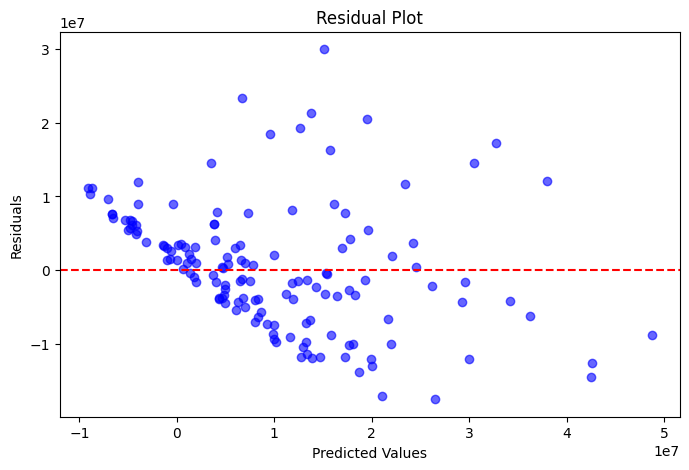

Training and Evaluating: RidgeRegression
RidgeRegression -> RMSE: 8197127.60, R²: 0.5079
📊 Model Evaluation Results:
🔹 R² Score - Train: 0.7234, Test: 0.5079
🔹 MSE - Train: 42356737367551.8281, Test: 67192900971152.2500
🔹 RMSE - Train: 6508205.3876, Test: 8197127.6049
🔹 MAE - Train: 4883707.0744, Test: 6236179.1036
🔹 Cross-Validation R² (Mean): 0.3883 ± 0.0891


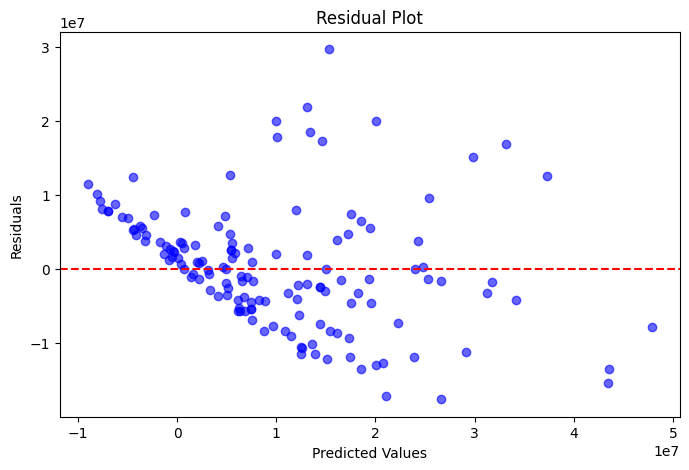

Training and Evaluating: LassoRegression
LassoRegression -> RMSE: 8211662.90, R²: 0.5062
📊 Model Evaluation Results:
🔹 R² Score - Train: 0.7274, Test: 0.5062
🔹 MSE - Train: 41736234585248.6328, Test: 67431407507611.0234
🔹 RMSE - Train: 6460358.7041, Test: 8211662.8954
🔹 MAE - Train: 4833074.2685, Test: 6312048.0787
🔹 Cross-Validation R² (Mean): 0.4009 ± 0.0834


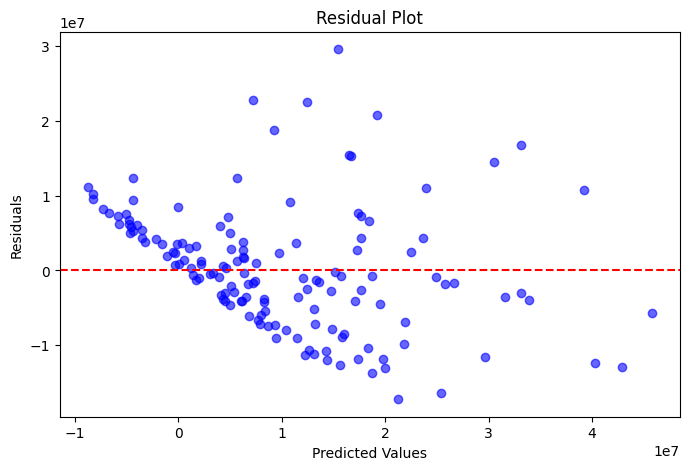

Training and Evaluating: ElasticNet
ElasticNet -> RMSE: 7785066.71, R²: 0.5562
📊 Model Evaluation Results:
🔹 R² Score - Train: 0.6973, Test: 0.5562
🔹 MSE - Train: 46356788247723.8281, Test: 60607263695171.7031
🔹 RMSE - Train: 6808581.9557, Test: 7785066.7110
🔹 MAE - Train: 5014485.1555, Test: 5742053.6732
🔹 Cross-Validation R² (Mean): 0.5131 ± 0.0313


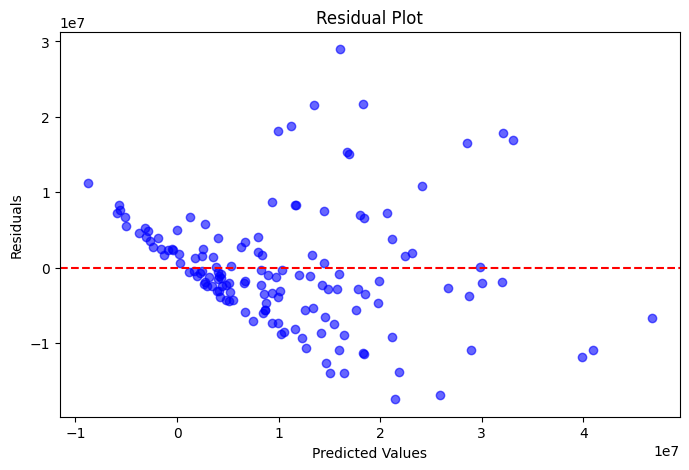

Training and Evaluating: XGBoost
XGBoost -> RMSE: 8392040.40, R²: 0.4843


KeyboardInterrupt: 

In [28]:
run_models_on_position(clean_data)

---


## Ensemble learning


In [ ]:
processed_df = clean_data_basic(clean_data)
train_and_evaluate_ensemble(processed_df)
train_and_evaluate_ensemble(processed_df)
train_and_evaluate_ensemble(processed_df)

---


## Feature Engineering


In [19]:
def add_pos_metrics(df, pos, drop=False):

    if (pos == 'Defender'):
        # Defensive Actions
        tackles = np.array(df["Tkl"])
        interceptions = np.array(df["Int"])
        blocks = np.array(df["Blocks"])
        clearances = np.array(df["Clr"])
        recoveries = np.array(df["Recov"])
        df["Defensive Actions"] = (
            tackles+interceptions+blocks+clearances+recoveries)/90
        # Aerial Duels
        df["Aerial Duels"] = np.array(df["Won%"])/90
        # Passing and Build-up Play
        key_passes = np.array(df["KP"])
        pass_cmp = np.array(df["Cmp%"])
        df["Passing and Build-up"] = (key_passes+pass_cmp)/90
        # Positioning and Defensive Awarness
        df["Defensive Awareness"] = (clearances+blocks)/90
        # Defensive Contributions
        yellow_cards = np.array(df["CrdY"])
        second_yellow_card = np.array(df["2CrdY"])
        red_cards = np.array(df["CrdR"])
        fouls = np.array(df["Fls"])
        df["Discipline"] = (yellow_cards+second_yellow_card+red_cards+fouls)/90

        # Defensive Duties
        tackles_Def_3rd = np.array(df["Def 3rd"])
        interceptions = np.array(df["Int"])
        df["Defensive Duties"] = (tackles_Def_3rd+interceptions)/90
        # Offensive Contribution
        prg_carries = np.array(df["PrgC"])
        prg_passes = np.array(df["PrgP"])
        key_passes = np.array(df["KP"])
        xA = np.array(df["xA"])
        df["Offensive Contributions"] = (
            prg_carries+prg_passes+xA+key_passes)/90
        # Final Third Play
        crosses_attempted = np.array(df["Crs"])
        shot_creating_actions = np.array(df["SCA"])
        carries_penalty_area = np.array(df["CPA"])
        df["Final Third Play"] = (
            crosses_attempted+shot_creating_actions+carries_penalty_area)/90
        # Possession Play
        TAtt3rd = np.array(df["Att 3rd_possession"])
        carry_distance = np.array(df["TotDist"])
        df["Possession Play"] = (TAtt3rd+carry_distance)/90
        # Dribbling and Transition Play
        successful_take_ons = np.array(df["Succ"])
        df["Dribbling"] = successful_take_ons/90

    elif (pos == 'Midfielder'):
        # Defensive Contributions
        tackles = np.array(df["Tkl"])
        interceptions = np.array(df["Int"])
        blocks = np.array(df["Blocks"])
        clearances = np.array(df["Clr"])
        recoveries = np.array(df["Recov"])
        df["Defensive Contributions"] = (
            tackles+interceptions+blocks+clearances+recoveries)/90
        # Passing Ability
        pass_cmp = np.array(df["Cmp%"])
        df["Passing Ability"] = pass_cmp/90
        # Build-up Play
        xA = np.array(df["xA"])
        xAG = np.array(df["xAG"])
        npxG = np.array(df["npxG"])
        df["Build-Up Play"] = (xA+xAG+npxG)/90
        # Ball Recovery and Defensive Work
        recoveries = np.array(df["Recov"])
        interceptions = np.array(df["Int"])
        df["Ball Recovery & Defensive Work"] = (recoveries+interceptions)/90
        # Defensive Line Breaking Passes
        prg_passes = np.array(df["PrgP"])
        key_passes = np.array(df["KP"])
        passes_final_third = np.array(df["1/3"])
        df["Line Breaking Passes"] = (
            key_passes+prg_passes+passes_final_third)/90

        # Passing and Vision
        prg_passes = np.array(df["PrgP"])
        passes_final_third = np.array(df["1/3"])
        df["Passing"] = (prg_passes+passes_final_third)/90
        # Ball Carrying
        successful_take_ons = np.array(df["Succ"])
        prg_carries = np.array(df["PrgC"])
        cpa = np.array(df["CPA"])
        df["Ball Carrying"] = (successful_take_ons+prg_carries+cpa)/90
        # Defensive Work
        tackles = np.array(df["Tkl"])
        interceptions = np.array(df["Int"])
        blocks = np.array(df["Blocks"])
        clearances = np.array(df["Clr"])
        recoveries = np.array(df["Recov"])
        df["Defensive Work"] = (tackles+interceptions +
                                blocks+clearances+recoveries)/90
        # Chance Creation
        sca = np.array(df["SCA"])
        xG = np.array(df["xG"])
        xA = np.array(df["xA"])
        xAG = np.array(df["xAG"])
        df["Chance Creation"] = (sca+xG+xA+xAG)/90
        # Possession Retention
        pass_cmp = np.array(df["Cmp"])
        key_passes = np.array(df["KP"])
        passes_final_third = np.array(df["1/3"])
        successful_take_ons = np.array(df["Succ"])
        df["Possession Retention"] = (
            pass_cmp+key_passes+passes_final_third+successful_take_ons)/90

        # Creativity and Playmaking
        xA = np.array(df["xA"])
        sca = np.array(df["SCA"])
        passes_final_third = np.array(df["1/3"])
        df["Playmaking"] = (xA+sca+passes_final_third)/90
        # Ball Progression
        prg_carries = np.array(df["PrgC"])
        prg_passes = np.array(df["PrgP"])
        df["Ball Progression"] = (prg_passes+prg_carries)/90
        # Final Third Impact
        TAtt3rd = np.array(df["Att 3rd_possession"])
        cpa = np.array(df["CPA"])
        ppa = np.array(df["PPA"])
        df["Final Third Impact"] = (TAtt3rd+cpa+ppa)/90
        # Goal Threat
        xG = np.array(df["xG"])
        npxG = np.array(df["npxG"])
        goal = np.array(df["Gls"])
        df["Goal Threat"] = (xG+npxG+goal)/90
        # Final Ball Efficiency
        passes_final_third = np.array(df["1/3_possession"])
        ppa = np.array(df['PPA'])
        df["Final Ball Efficiency"] = (passes_final_third+ppa)/90

    elif (pos == "Forward"):
        # Dribbling and Ball Carrying
        successful_take_ons = np.array(df["Succ"])
        prg_carries = np.array(df["PrgC"])
        cpa = np.array(df["CPA"])
        df["Dribbling"] = (successful_take_ons+prg_carries+cpa)/90
        # Crossing and Playmaking
        xA = np.array(df["xA"])
        xAG = np.array(df["xAG"])
        crosses_attempted = np.array(df["Crs"])
        df["Crosses and Playmaking"] = (xA+xAG+crosses_attempted)/90
        # Goal Threat
        xG = np.array(df["xG"])
        npxG = np.array(df["npxG"])
        goal = np.array(df["Gls"])
        df["Goal Threat"] = (xG+npxG+goal)/90
        # Final Third Involvement
        TAtt3rd = np.array(df["Att 3rd_possession"])
        cpa = np.array(df["CPA"])
        ppa = np.array(df["PPA"])
        df["Final Third Impact"] = (TAtt3rd+cpa+ppa)/90
        # Ball Carrying
        successful_take_ons = np.array(df["Succ"])
        prg_carries = np.array(df["PrgC"])
        cpa = np.array(df["CPA"])
        df["Ball Carrying"] = (successful_take_ons+prg_carries+cpa)/90

        # Goal Threat
        xG = np.array(df["xG"])
        npxG = np.array(df["npxG"])
        goal = np.array(df["Gls"])
        df["Goal Threat"] = (xG+npxG+goal)/90
        # Chance Conversion
        npGoals = np.array(df["G_PK"])/90
        xG = np.array(df["xG"])/90
        df["Chance Conversion"] = npGoals/xG
        # Link-up Play
        prg_received = np.array(df["PrgR"])
        passes_final_third = np.array(df["1/3_possession"])
        xA = np.array(df["xA"])
        ppa = np.array(df["PPA"])
        df["Link-Up Play"] = (prg_received+xA+ppa)/90
        # Shooting Accuracy
        SoT = np.array(df["SoT/90"])
        shots = np.array(df["Sh/90"])
        df["Shooting Accuracy"] = SoT+shots
        # Penalty Box Presence
        TAttPen = np.array(df["Att Pen"])
        df["Penalty Box Presence"] = TAttPen/90

    elif (pos == "Goalkeeper"):
        # Shot Stopping Ability
        saves = np.array(df["Saves"])
        df["Shot Stopping"] = saves/90
        # Expected Goals Prevented
        psxG = np.array(df["PSxG"]/90)
        ga = np.array(df["GA"]/90)
        df["Expected Goals Prevented"] = psxG-ga
        # Cross and Aerial Control
        crosses_stopped = np.array(df["Stp"])
        df["Cross and Aerial Control"] = crosses_stopped/90
        # Sweeper Keeper Activity
        sweeper = np.array(df["_OPA/90"])
        df["Sweeper Keeper Activity"] = sweeper
        # Passing and Distribution
        passes_cmp = np.array(df["Cmp"])
        df["Passing"] = passes_cmp/90

    return df

In [68]:
dfs, mf, gk, fw = split_by_position(df=clean_data)
dfs = add_pos_metrics(dfs, "Defender", drop=True)
mf = add_pos_metrics(mf, "Midfielder", drop=True)
fw = add_pos_metrics(fw, "Forward", drop=True)
gk = add_pos_metrics(gk, "Goalkeeper", drop=True)

feature_df = pd.concat([dfs, mf, fw, gk], ignore_index=True)

RAW_COLUMNS_TO_DROP = {
    'Tkl', 'Int', 'Blocks', 'Clr', 'Recov', 'Won%', 'KP', 'Cmp%', 'CrdY',
    '2CrdY', 'CrdR', 'Fls', 'Def 3rd', 'PrgC', 'PrgP', 'xA', 'Crs', 'SCA',
    'CPA', 'Att 3rd_possession', 'TotDist', 'Succ', 'xAG', 'npxG', 'xG',
    '1/3', 'Gls', 'Cmp', 'PPA', 'G_PK', 'PrgR', '1/3_possession',
    'SoT/90', 'Sh/90', 'Att Pen', 'Saves', 'GA', 'PSxG', 'Stp', '_OPA/90'
}

feature_df.drop(
    columns=[col for col in RAW_COLUMNS_TO_DROP if col in df.columns], inplace=True)

In [ ]:
# dfs, mf, gk, fw = split_by_position(df=clean_data)
# for pos, df in zip(["Defender", "Midfielder", "Forward", "Goalkeeper"], [df, mf, fw, gk]):
#     df = add_pos_metrics(df, pos)
#     stacking = train_and_evaluate_ensemble(df)

#     print(
#         f"Position: {pos}:\n\tStacking: {stacking}\n")

---


## PCA Inclusion


In [36]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


def find_optimal_components(df, variance_threshold=0.95):
    numeric_df = df.select_dtypes(include=['number'])

    # Standardize the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(numeric_df)

    # Perform PCA
    pca = PCA()
    pca.fit(scaled_data)

    # Compute cumulative explained variance
    explained_variance = np.cumsum(pca.explained_variance_ratio_)

    # Find the number of components that explain the desired variance
    optimal_components = np.argmax(
        explained_variance >= variance_threshold) + 1

    # Plot explained variance
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(explained_variance) + 1),
             explained_variance, marker='o', linestyle='--', color='b')
    plt.axhline(y=variance_threshold, color='r', linestyle='--')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('Explained Variance vs. Number of Components')
    plt.grid()
    plt.show()

    return optimal_components

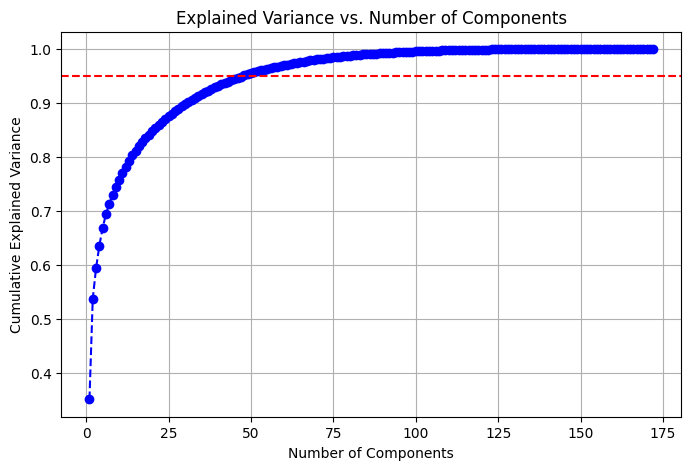

Optimal number of components: 48


In [37]:
optimal_n = find_optimal_components(clean_data, variance_threshold=0.95)
print(f"Optimal number of components: {optimal_n}")

In [38]:
eigenvalues = PCA().fit(StandardScaler().fit_transform(
    clean_data.select_dtypes(include=['number']))).explained_variance_
optimal_n_kaiser = sum(eigenvalues > 1)
print(f"Optimal components based on Kaiser's Rule: {optimal_n_kaiser}")

Optimal components based on Kaiser's Rule: 18


In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


def perform_pca(df, n_components=2):
    """
    Performs PCA on the given DataFrame and returns the transformed DataFrame.

    Parameters:
        df (pd.DataFrame): The input DataFrame with numerical values.
        n_components (int): The number of principal components to keep.

    Returns:
        pd.DataFrame: Transformed DataFrame with principal components.
        PCA: The trained PCA model.
    """

    # Drop non-numeric columns
    numeric_df = df.select_dtypes(include=['number'])

    # Standardize the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(numeric_df)

    # Apply PCA
    pca = PCA(n_components=n_components)
    pca_transformed = pca.fit_transform(scaled_data)

    # Create a DataFrame with principal components
    pca_df = pd.DataFrame(pca_transformed, columns=[
                          f'PC{i+1}' for i in range(n_components)])
    marketValue = df["marketValue"]
    # Retain non-numeric columns for reference
    non_numeric_df = df.select_dtypes(
        exclude=['number']).reset_index(drop=True)
    result_df = pd.concat([non_numeric_df, pca_df], axis=1)
    result_df["marketValue"] = marketValue
    return result_df, pca


reduced_df, pca_model = perform_pca(clean_data, n_components=42)
reduced_df.head()

,Nation,Squad,Comp,position,nationality,foot,contract,PC1,PC2,PC3,...,PC34,PC35,PC36,PC37,PC38,PC39,PC40,PC41,PC42,marketValue
0,ENG,West Ham,eng Premier League,Left-Back,['England'],left,2025-06-30,-4.769904,-2.315295,3.428809,...,-0.100577,-1.340562,-1.754598,-0.545299,-0.017928,-0.274724,0.219424,0.125030,-0.754349,700000.0
1,ENG,Southampton,eng Premier League,Goalkeeper,['England'],right,2028-06-30,-3.060442,-8.005960,-2.920658,...,-0.178030,0.290969,-0.352748,1.262025,1.214001,0.293049,0.018002,-0.225758,0.333151,20000000.0
2,ESP,Genoa,it Serie A,Left-Back,['Spain'],left,2026-06-30,13.664591,-4.006377,6.064771,...,-0.196131,-0.176087,0.385031,-0.115779,-0.528808,-0.179979,0.912648,-0.712817,1.176287,5000000.0
3,CIV,Strasbourg,fr Ligue 1,Centre-Back,"[""Cote d'Ivoire""]",left,2028-06-30,-2.759293,-4.726964,-1.925850,...,0.422945,0.178941,0.101595,-0.001145,0.408314,0.203946,-0.396873,0.640982,0.029762,12000000.0
4,SEN,Brest,fr Ligue 1,Right Winger,['Senegal'],right,2025-06-30,0.076593,9.478839,-4.259001,...,-0.413902,0.011863,-0.390872,0.666744,-1.061495,-0.076413,0.451343,0.126086,0.169885,10000000.0


---


## PCA with individual models


In [24]:
def pca_on_individual_model(df):
    models = {}

    df, mf, gk, fw = split_by_position(df=df)

    # for df, pos in zip([df, mf, fw, gk], ["Defender", "Midfielder", "Forward", "Goalkeeper"]):
    # df = add_pos_metrics(df, pos)

    for position, df_position in zip([
            "Defenders", "Midfielders", "Forwards", "Goalkeepers"],
            [df, mf, fw, gk]):

        if df_position.empty:
            continue

        df_position = clean_data_basic(df_position)
        best_model, best_rmse, best_r2 = None, float("inf"), -float("inf")

        for model_name in [
            "LinearRegression", "RidgeRegression", "LassoRegression",
            "ElasticNet",
            "XGBoost", "LightGBM", "RandomForest", "GradientBoosting",
                "AdaBoost"]:
            model, rmse, r2 = train_and_evaluate(df_position, model_name)
            if rmse < best_rmse:
                best_model, best_rmse, best_r2 = model, rmse, r2

        models[position] = best_model
        print(
            f"\nBest model for {position}: {type(best_model).__name__} (RMSE: {best_rmse:.2f}, R²: {best_r2:.4f})\n")

    return models

In [ ]:
pca_on_individual_model(reduced_df)

---


## PCA + Ensemble Learning


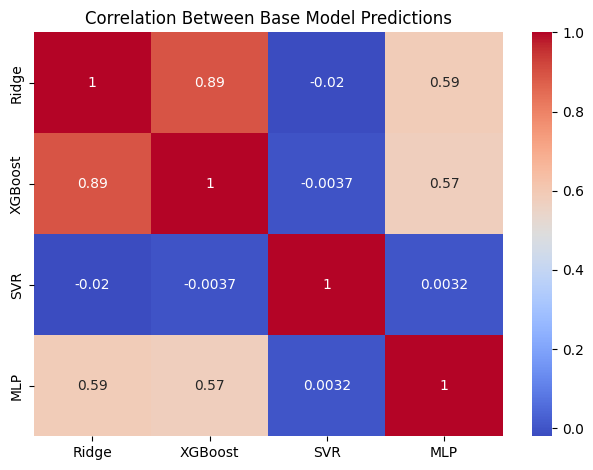

Stacking-log Ensemble -> RMSE: 3260592.31, R²: 0.9404
📊 Model Evaluation Results:
🔹 R² Score - Train: 0.9767, Test: 0.9404
🔹 MSE - Train: 4229122148434.7334, Test: 10631462227737.7285
🔹 RMSE - Train: 2056482.9560, Test: 3260592.3124
🔹 MAE - Train: 1381460.5772, Test: 2264693.8664
🔹 Cross-Validation R² (Mean): 0.9322 ± 0.0061


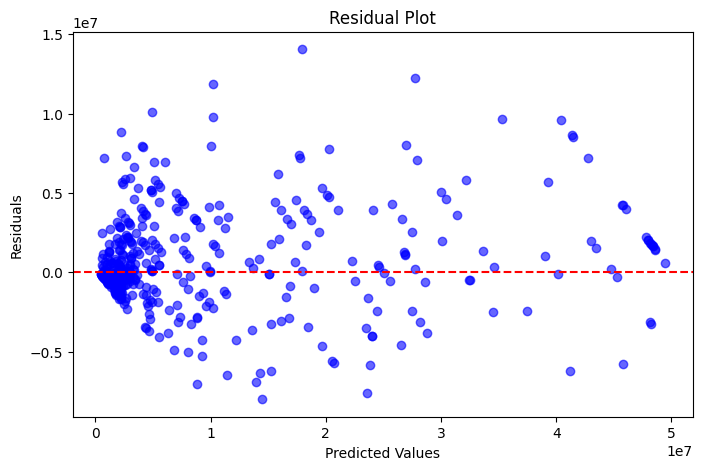

In [80]:
model, X_train, X_test, y_train, y_test, y_pred = train_and_evaluate_ensemble(
    reduced_df)

In [ ]:
# save the model to a pickle
import pickle

with open('model_10-05.pkl', 'wb') as file:
    pickle.dump(model, file)

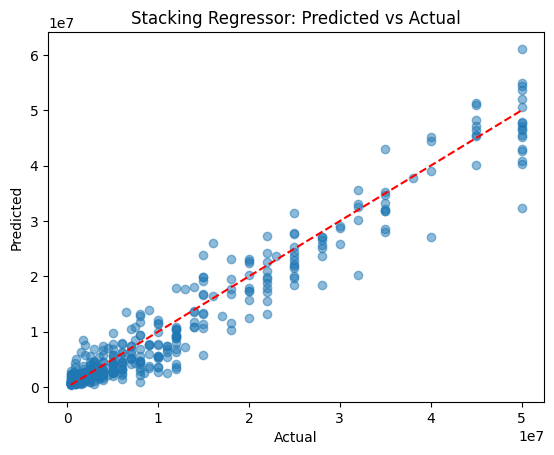

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Stacking Regressor: Predicted vs Actual')

plt.show()

In [3]:
import pickle
with open('model_10-05.pkl', 'rb') as file:
    model = pickle.load(file)

In [4]:
residuals = y_pred - y_test

plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

NameError: name 'y_pred' is not defined

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

meta_model = model.final_estimator_

# Extract importances or coefficients
if hasattr(meta_model, "coef_"):
    importances = meta_model.coef_
elif hasattr(meta_model, "feature_importances_"):
    importances = meta_model.feature_importances_
else:
    raise ValueError(
        "Meta-model does not support feature importances or coefficients.")

base_model_names = [name for name, _ in model.estimators]


# Check length match
assert len(importances) == len(
    base_model_names), "Mismatch between base model names and importances!"

# Plot
sns.barplot(x=base_model_names, y=importances)
plt.title('Meta-model Feature Importances')
plt.ylabel('Importance')
plt.xlabel('Base Models')
plt.show()

AttributeError: 'TransformedTargetRegressor' object has no attribute 'final_estimator_'